<a href="https://colab.research.google.com/github/iamviji/project/blob/master/misc/PyLDPC_CommPy_ITPP_BER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/veeresht/CommPy.git
import sys
sys.path.append('./CommPy')

Cloning into 'CommPy'...
remote: Enumerating objects: 181, done.
remote: Counting objects: 100% (181/181), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 2064 (delta 115), reused 114 (delta 72), pack-reused 1883
Receiving objects: 100% (2064/2064), 1.43 MiB | 1.61 MiB/s, done.
Resolving deltas: 100% (1273/1273), done.


In [2]:
import commpy.channels as chan
import commpy.modulation as mod
import commpy.utilities as util
!pip install pyldpc

     |████████████████████████████████| 1.1MB 2.7MB/s 
  Created wheel for pyldpc: filename=pyldpc-0.7.9-cp36-none-any.whl size=14306 sha256=d3780e91a368cedc60df9ed50c187f0407f783a6a36e65506fb39e4bbc183980
  Stored in directory: /root/.cache/pip/wheels/47/7a/10/e94058ba8b0b6d98bf2719226d18d3dd6056525ad7b984c068
Successfully built pyldpc


In [3]:
import pyldpc
import numpy 
import time


In [4]:
SNR_BEGIN = 0
SNR_END = 10
SNR_STEP_SIZE = 0.5
CHANEL_SIZE = 18
NUM_OF_INPUT_MESSAGE = 1000
LDPC_MAX_ITER = 100
num_parity_check = 8
num_bits_in_parity_check = 9 
input_message_length =  0 # Caculated by channel encoder and initialized later

In [5]:
def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff

def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma

def pyldpc_encode (CodingMatrix, message):
  rng = pyldpc.utils.check_random_state(seed=None)
  d = pyldpc.utils.binaryproduct(CodingMatrix, message)
  encoded_message = (-1) ** d
  return encoded_message

def pyldpc_decode (ParityCheckMatrix, CodingMatrix, message, snr, maxiter):
  decoded_msg = pyldpc.decode(ParityCheckMatrix, message, snr, maxiter)
  out_message = pyldpc.get_message(CodingMatrix, decoded_msg)
  return out_message



In [6]:

ParityCheckMatrix, CodingMatrix = pyldpc.make_ldpc(CHANEL_SIZE, num_parity_check, num_bits_in_parity_check, systematic=True, sparse=True)
input_message_length = CodingMatrix.shape[1]
print ("input_message_size=", input_message_length, "channel_size=",CHANEL_SIZE)
print ("input_message_size=", CodingMatrix.shape[1], "channel_size=",CodingMatrix.shape[0])
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))
print (input_message)

input_message_size= 9 channel_size= 18
input_message_size= 9 channel_size= 18
[[1 0 1 ... 0 0 1]
 [1 0 1 ... 1 1 1]
 [1 0 1 ... 0 1 0]
 ...
 [0 1 0 ... 1 0 1]
 [0 0 0 ... 1 0 1]
 [1 1 0 ... 0 0 0]]


In [7]:
import commpy
# Here I am using commpy based AWGN 
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_pyldpc  = numpy.array(())
times_per_iter_pyldpc= numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc.encode (CodingMatrix, input_message[i], snr)
    awgn_channel_output_message = encoded_message
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)    
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_pyldpc=numpy.append(bler_per_iter_pyldpc ,ber)
  times_per_iter_pyldpc=numpy.append(times_per_iter_pyldpc, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 6.78s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 13.62s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 21.19s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 27.99s
SNR: 0.000:
 -> BER: 0.63
 -> Total Time: 69.58s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 6.15s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 12.81s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 19.22s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 25.19s
SNR: 0.500:
 -> BER: 0.57
 -> Total Time: 63.36s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 4.76s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 9.93s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 15.42s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 20.64s
SNR: 1.000:
 -> BER: 0.45
 -> Total Time: 50.74s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 4.82s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 9.73s
SNR: 1.500 - Iter: 750 - Last 

In [8]:
modem = mod.PSKModem(2)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_pyldpc_commpy_psk_2  = numpy.array(())
times_per_iter_pyldpc_commpy_psk_2= numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (encoded_message)
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    dmodem_output = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_pyldpc_commpy_psk_2=numpy.append(bler_per_iter_pyldpc_commpy_psk_2 ,ber)
  times_per_iter_pyldpc_commpy_psk_2=numpy.append(times_per_iter_pyldpc_commpy_psk_2, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 6.48s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 13.16s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 19.39s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 26.02s
SNR: 0.000:
 -> BER: 0.56
 -> Total Time: 65.06s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 5.65s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 11.83s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 17.56s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 23.61s
SNR: 0.500:
 -> BER: 0.47
 -> Total Time: 58.65s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 5.29s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 10.91s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 15.92s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 21.31s
SNR: 1.000:
 -> BER: 0.40
 -> Total Time: 53.44s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 4.33s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 9.40s
SNR: 1.500 - Iter: 750 - Last

In [9]:
modem = mod.PSKModem(4) #QPSK
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_pyldpc_commpy_psk_4  = numpy.array(())
times_per_iter_pyldpc_commpy_psk_4= numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (encoded_message)
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    dmodem_output = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_pyldpc_commpy_psk_4=numpy.append(bler_per_iter_pyldpc_commpy_psk_4 ,ber)
  times_per_iter_pyldpc_commpy_psk_4=numpy.append(times_per_iter_pyldpc_commpy_psk_4, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 7.85s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 15.63s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 23.13s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 30.84s
SNR: 0.000:
 -> BER: 0.80
 -> Total Time: 77.44s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 7.56s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 15.08s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 23.12s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 30.69s
SNR: 0.500:
 -> BER: 0.77
 -> Total Time: 76.44s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 7.53s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 14.84s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 21.95s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 29.67s
SNR: 1.000:
 -> BER: 0.72
 -> Total Time: 74.00s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 7.18s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 14.73s
SNR: 1.500 - Iter: 750 - Las

In [10]:
input_message_uncoded = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,9))

modem = mod.PSKModem(2)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_commpy_psk_2  = numpy.array(())
times_per_iter_uncoded_commpy_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    #encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    #encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (input_message_uncoded[i])
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    decoded_message = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    #decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message_uncoded[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_uncoded_commpy_psk_2=numpy.append(bler_per_iter_uncoded_commpy_psk_2 ,ber)
  times_per_iter_uncoded_commpy_psk_2=numpy.append(times_per_iter_uncoded_commpy_psk_2, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.07s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.10s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.13s
SNR: 0.000:
 -> BER: 0.49
 -> Total Time: 0.32s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.09s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.13s
SNR: 0.500:
 -> BER: 0.47
 -> Total Time: 0.31s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.09s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.12s
SNR: 1.000:
 -> BER: 0.40
 -> Total Time: 0.30s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.08s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [11]:
input_message_uncoded = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,10))

modem = mod.PSKModem(4)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_commpy_psk_4  = numpy.array(())
times_per_iter_uncoded_commpy_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    #encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    #encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (input_message_uncoded[i])
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    decoded_message = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    #decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message_uncoded[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_uncoded_commpy_psk_4=numpy.append(bler_per_iter_uncoded_commpy_psk_4 ,ber)
  times_per_iter_uncoded_commpy_psk_4=numpy.append(times_per_iter_uncoded_commpy_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.09s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.12s
SNR: 0.000:
 -> BER: 0.82
 -> Total Time: 0.31s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.09s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.12s
SNR: 0.500:
 -> BER: 0.77
 -> Total Time: 0.30s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.10s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.13s
SNR: 1.000:
 -> BER: 0.75
 -> Total Time: 0.33s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

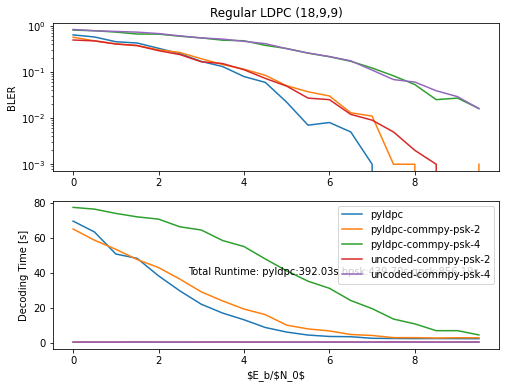

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2 ,'', label="uncoded-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax1.set_ylabel('BLER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_uncoded_commpy_psk_2,'', label="uncoded-commpy-psk-2") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot decode timing for different SNRs
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s bpsk:{:03.2f}s qpsk:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_pyldpc_commpy_psk_2), numpy.sum(times_per_iter_pyldpc_commpy_psk_4)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [13]:
!sudo apt-get install autoconf
!sudo apt-get install libtool
!sudo apt-get install liblapack-dev libblas-dev libfftw3-dev
!rm -rf itpp
!git clone https://github.com/iamviji/itpp.git # original one had compilation issue, did minor signle line change after forking
!ls;cd itpp;ls;mkdir -p build1 build2; cd build1 ; cmake cmake ..;make ;make install
!rm -rf py-itpp
!git clone https://github.com/iamviji/py-itpp.git
!pip3 install pybind11
!cd py-itpp;./install_prerequisites_python3.sh;make install;pip3 install -e .  
!cd py-itpp; ls ; pip3 install -e .  
!cat py-itpp/setup.py
import sys
!cp -rf py-itpp/lib/itpp py-itpp/lib/pyitpp # import itpp is not working, after this hack i started to work
sys.path.append('./py-itpp/lib')
#!pip install gwpy &> /dev/null

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  automake autotools-dev libsigsegv2 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc libtool gettext m4-doc
The following NEW packages will be installed:
  autoconf automake autotools-dev libsigsegv2 m4
0 upgraded, 5 newly installed, 0 to remove and 11 not upgraded.
Need to get 1,082 kB of archives.
After this operation, 3,994 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libsigsegv2 amd64 2.12-1 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 m4 amd64 1.4.18-1 [197 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 autoconf all 2.69-11 [322 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 autotools-dev all 20180224.1 [39.6 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/main amd64 automake all 1:1.15.1-3ubuntu2 [509 kB]
Fet

In [14]:
import pyitpp as itpp
from matplotlib import pyplot as plt

In [15]:
nrof_bits = 9
modulator = itpp.comm.PSK(2)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_itpp_psk_2  = numpy.array(())
times_per_iter_uncoded_itpp_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    tx_signal = modulator.modulate_bits(source_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    if abs(demodulated_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_uncoded_itpp_psk_2=numpy.append(bler_per_iter_uncoded_itpp_psk_2 ,ber)
  times_per_iter_uncoded_itpp_psk_2=numpy.append(times_per_iter_uncoded_itpp_psk_2, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 0.000:
 -> BER: 0.52
 -> Total Time: 0.06s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 0.500:
 -> BER: 0.48
 -> Total Time: 0.06s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 1.000:
 -> BER: 0.41
 -> Total Time: 0.04s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [16]:
nrof_bits = 9
modulator = itpp.comm.BPSK()
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_itpp_bpsk  = numpy.array(())
times_per_iter_uncoded_itpp_bpsk = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    tx_signal = modulator.modulate_bits(source_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    if abs(demodulated_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_uncoded_itpp_bpsk=numpy.append(bler_per_iter_uncoded_itpp_bpsk ,ber)
  times_per_iter_uncoded_itpp_bpsk=numpy.append(times_per_iter_uncoded_itpp_bpsk, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.01s
SNR: 0.000:
 -> BER: 0.77
 -> Total Time: 0.04s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 0.500:
 -> BER: 0.77
 -> Total Time: 0.04s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 1.000:
 -> BER: 0.73
 -> Total Time: 0.05s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [17]:
nrof_bits = 10
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_itpp_psk_4  = numpy.array(())
times_per_iter_uncoded_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    tx_signal = modulator.modulate_bits(source_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    if abs(demodulated_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_uncoded_itpp_psk_4=numpy.append(bler_per_iter_uncoded_itpp_psk_4 ,ber)
  times_per_iter_uncoded_itpp_psk_4=numpy.append(times_per_iter_uncoded_itpp_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 0.000:
 -> BER: 0.81
 -> Total Time: 0.05s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 0.500:
 -> BER: 0.77
 -> Total Time: 0.05s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.02s
SNR: 1.000:
 -> BER: 0.73
 -> Total Time: 0.04s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.00s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

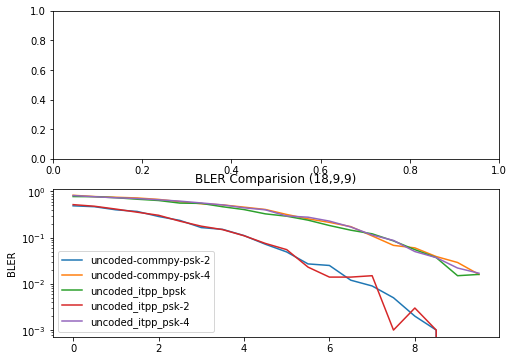

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2 ,'', label="uncoded-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_bpsk,'', label="uncoded_itpp_bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="uncoded_itpp_psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_4,'', label="uncoded_itpp_psk-4") # plot BER vs SNR
ax2.set_ylabel('BLER')
ax2.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [19]:
nrof_bits = 8 #Hamming(7,4,3) But x2
hamm = itpp.comm.Hamming_Code(3)
modulator = itpp.comm.BPSK()
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ham_itpp_bpsk  = numpy.array(())
times_per_iter_ham_itpp_bpsk = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = hamm.encode(source_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    decoded_bits = hamm.decode(demodulated_bits) 
    #print (source_bits)
    #print (decoded_bits)
    if abs(decoded_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_ham_itpp_bpsk=numpy.append(bler_per_iter_ham_itpp_bpsk ,ber)
  times_per_iter_ham_itpp_bpsk=numpy.append(times_per_iter_ham_itpp_bpsk, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 0.000:
 -> BER: 0.54
 -> Total Time: 0.08s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 0.500:
 -> BER: 0.45
 -> Total Time: 0.07s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 1.000:
 -> BER: 0.41
 -> Total Time: 0.07s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [20]:
nrof_bits = 8 #Hamming(7,4,3) But x2
hamm = itpp.comm.Hamming_Code(3)
modulator = itpp.comm.PSK(2)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ham_itpp_psk_2  = numpy.array(())
times_per_iter_ham_itpp_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = hamm.encode(source_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    decoded_bits = hamm.decode(demodulated_bits) 
    #print (source_bits)
    #print (decoded_bits)
    if abs(decoded_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_ham_itpp_psk_2=numpy.append(bler_per_iter_ham_itpp_psk_2 ,ber)
  times_per_iter_ham_itpp_psk_2=numpy.append(times_per_iter_ham_itpp_psk_2, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 0.000:
 -> BER: 0.18
 -> Total Time: 0.09s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 0.500:
 -> BER: 0.14
 -> Total Time: 0.08s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 1.000:
 -> BER: 0.11
 -> Total Time: 0.09s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [21]:
nrof_bits = 8 #Hamming(7,4,3) But x2
hamm = itpp.comm.Hamming_Code(3)
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ham_itpp_psk_4  = numpy.array(())
times_per_iter_ham_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    #print ("x")
    #print (source_bits)
    encoded_bits = hamm.encode(source_bits)
    #print (encoded_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    #print (demodulated_bits)
    decoded_bits = hamm.decode(demodulated_bits) 
    #print (decoded_bits)
    if abs(decoded_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_ham_itpp_psk_4=numpy.append(bler_per_iter_ham_itpp_psk_4 ,ber)
  times_per_iter_ham_itpp_psk_4=numpy.append(times_per_iter_ham_itpp_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 0.000:
 -> BER: 0.52
 -> Total Time: 0.07s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 0.500:
 -> BER: 0.45
 -> Total Time: 0.08s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 1.000:
 -> BER: 0.38
 -> Total Time: 0.08s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

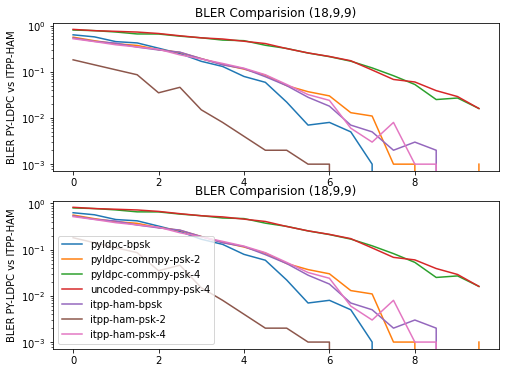

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax1.set_ylabel('BLER PY-LDPC vs ITPP-HAM')
ax1.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax2.set_ylabel('BLER PY-LDPC vs ITPP-HAM')
ax2.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [22]:
nrof_bits =14
bch = itpp.comm.bch(15, 2, False)
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_bch_itpp_psk_4  = numpy.array(())
times_per_iter_bch_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = itpp.base.bvec ()
    #print ("x")
    #print (source_bits)
    bch.encode(source_bits, encoded_bits)
    #print (encoded_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    #print (demodulated_bits)
    decoded_bits = itpp.base.bvec ()
    bch.decode(demodulated_bits, decoded_bits) 
    #print (decoded_bits)
    if abs(decoded_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_bch_itpp_psk_4=numpy.append(bler_per_iter_bch_itpp_psk_4 ,ber)
  times_per_iter_bch_itpp_psk_4=numpy.append(times_per_iter_bch_itpp_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.09s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.13s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.17s
SNR: 0.000:
 -> BER: 0.67
 -> Total Time: 0.44s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.07s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.11s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.15s
SNR: 0.500:
 -> BER: 0.59
 -> Total Time: 0.37s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.07s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.11s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.15s
SNR: 1.000:
 -> BER: 0.52
 -> Total Time: 0.37s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.07s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

In [34]:
options =itpp.ivec("18 6")
ind =itpp.ivec("")
ldpc_parity_reg = itpp.comm.ldpc_parity_regular (18, 3, 6, 'rand', options)
ldpc_gen_sym = itpp.comm.ldpc_gen_systematic (ldpc_parity_reg, False, ind)
ldpc_code = itpp.comm.ldpc_code (ldpc_parity_reg, ldpc_gen_sym, False)
nrof_bits = ldpc_code.get_nvar ()  - ldpc_code.get_ncheck ()
print ("nrof_bits=", nrof_bits, "nvar=", ldpc_code.get_nvar (), "ncheck=",ldpc_code.get_ncheck ())
modulator = itpp.comm.PSK(2)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ldpc_itpp_psk_2  = numpy.array(())
times_per_iter_ldpc_itpp_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = ldpc_code.encode(source_bits)
    #print ("x")
    #print (source_bits)
    #print (encoded_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    #demodulated_bits = modulator.demodulate_bits(rx_signal)
    demodulated_soft_bits = modulator.demodulate_soft_bits(rx_signal, noise_variance / ldpc_code.get_rate(), itpp.comm.Soft_Method.LOGMAP)
    #print (demodulated_soft_bits)
    decoded_soft_bits = ldpc_code.decode_soft_out(demodulated_soft_bits)
    decoded_bits = ldpc_code.decode(decoded_soft_bits)
    #print (decoded_bits)
    if abs(decoded_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_ldpc_itpp_psk_2=numpy.append(bler_per_iter_ldpc_itpp_psk_2 ,ber)
  times_per_iter_ldpc_itpp_psk_2=numpy.append(times_per_iter_ldpc_itpp_psk_2, total_time)

nrof_bits= 9 nvar= 18 ncheck= 9
SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.07s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.12s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.18s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.23s
SNR: 0.000:
 -> BER: 0.11
 -> Total Time: 0.60s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.08s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.12s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.17s
SNR: 0.500:
 -> BER: 0.07
 -> Total Time: 0.42s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.07s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.10s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.13s
SNR: 1.000:
 -> BER: 0.04
 -> Total Time: 0.33s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.05s
SNR: 1.50

In [35]:
options =itpp.ivec("18 6")
ind =itpp.ivec("")
ldpc_parity_reg = itpp.comm.ldpc_parity_regular (18, 3, 6, 'rand', options)
ldpc_gen_sym = itpp.comm.ldpc_gen_systematic (ldpc_parity_reg, False, ind)
ldpc_code = itpp.comm.ldpc_code (ldpc_parity_reg, ldpc_gen_sym, False)
nrof_bits = ldpc_code.get_nvar ()  - ldpc_code.get_ncheck ()
print ("nrof_bits=", nrof_bits, "nvar=", ldpc_code.get_nvar (), "ncheck=",ldpc_code.get_ncheck ())
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ldpc_itpp_psk_4  = numpy.array(())
times_per_iter_ldpc_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = ldpc_code.encode(source_bits)
    #print ("x")
    #print (source_bits)
    #print (encoded_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    #demodulated_bits = modulator.demodulate_bits(rx_signal)
    demodulated_soft_bits = modulator.demodulate_soft_bits(rx_signal, noise_variance / ldpc_code.get_rate(), itpp.comm.Soft_Method.LOGMAP)
    #print (demodulated_soft_bits)
    decoded_soft_bits = ldpc_code.decode_soft_out(demodulated_soft_bits)
    decoded_bits = ldpc_code.decode(decoded_soft_bits)
    #print (decoded_bits)
    if abs(decoded_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_ldpc_itpp_psk_4=numpy.append(bler_per_iter_ldpc_itpp_psk_4 ,ber)
  times_per_iter_ldpc_itpp_psk_4=numpy.append(times_per_iter_ldpc_itpp_psk_4, total_time)

nrof_bits= 9 nvar= 18 ncheck= 9
SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.19s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.38s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.56s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.76s
SNR: 0.000:
 -> BER: 0.60
 -> Total Time: 1.89s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.17s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.35s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.53s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.70s
SNR: 0.500:
 -> BER: 0.52
 -> Total Time: 1.74s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.14s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.31s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.47s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.61s
SNR: 1.000:
 -> BER: 0.47
 -> Total Time: 1.54s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.12s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.26s
SNR: 1.50

In [38]:
options =itpp.ivec("18 6")
ind =itpp.ivec("")
ldpc_parity_reg = itpp.comm.ldpc_parity_regular (18, 3, 6, 'rand', options)
ldpc_gen_sym = itpp.comm.ldpc_gen_systematic (ldpc_parity_reg, False, ind)
ldpc_code = itpp.comm.ldpc_code (ldpc_parity_reg, ldpc_gen_sym, False)
nrof_bits = ldpc_code.get_nvar ()  - ldpc_code.get_ncheck ()
print ("nrof_bits=", nrof_bits, "nvar=", ldpc_code.get_nvar (), "ncheck=",ldpc_code.get_ncheck ())
modulator = itpp.comm.BPSK()
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ldpc_itpp_bpsk  = numpy.array(())
times_per_iter_ldpc_itpp_bpsk = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = ldpc_code.encode(source_bits)
    #print ("x")
    #print (source_bits)
    #print (encoded_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    #demodulated_bits = modulator.demodulate_bits(rx_signal)
    demodulated_soft_bits = modulator.demodulate_soft_bits(rx_signal, noise_variance / ldpc_code.get_rate(), itpp.comm.Soft_Method.LOGMAP)
    #print (demodulated_soft_bits)
    decoded_soft_bits = ldpc_code.decode_soft_out(demodulated_soft_bits)
    decoded_bits = ldpc_code.decode(decoded_soft_bits)
    #print (decoded_bits)
    if abs(decoded_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_ldpc_itpp_bpsk=numpy.append(bler_per_iter_ldpc_itpp_bpsk ,ber)
  times_per_iter_ldpc_itpp_bpsk=numpy.append(times_per_iter_ldpc_itpp_bpsk, total_time)

nrof_bits= 9 nvar= 18 ncheck= 9
SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.14s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.29s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.42s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.56s
SNR: 0.000:
 -> BER: 0.50
 -> Total Time: 1.41s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.12s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.25s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.36s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.48s
SNR: 0.500:
 -> BER: 0.45
 -> Total Time: 1.20s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.11s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.20s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.29s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.39s
SNR: 1.000:
 -> BER: 0.38
 -> Total Time: 0.99s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.07s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.15s
SNR: 1.50

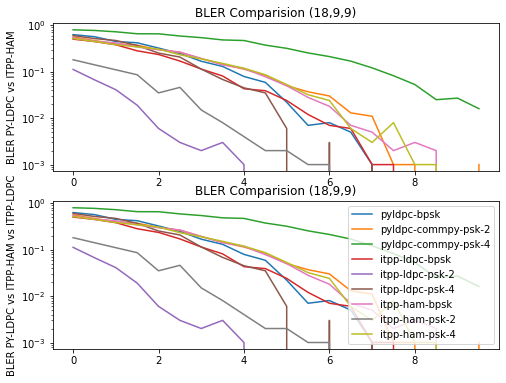

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_bpsk,'', label="itpp-ldpc-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_2,'', label="itpp-ldpc-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax1.set_ylabel('BLER PY-LDPC vs ITPP-HAM')
ax1.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ldpc_itpp_bpsk,'', label="itpp-ldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_2,'', label="itpp-ldpc-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax2.set_ylabel('BLER PY-LDPC vs ITPP-HAM vs ITPP-LDPC')
ax2.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

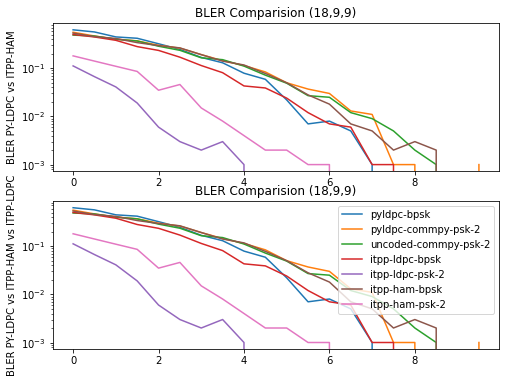

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2,'', label="uncoded-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_bpsk,'', label="itpp-ldpc-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_2,'', label="itpp-ldpc-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax1.set_ylabel('BLER PY-LDPC vs ITPP-HAM')
ax1.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2,'', label="uncoded-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ldpc_itpp_bpsk,'', label="itpp-ldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_2,'', label="itpp-ldpc-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax2.set_ylabel('BLER PY-LDPC vs ITPP-HAM vs ITPP-LDPC')
ax2.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

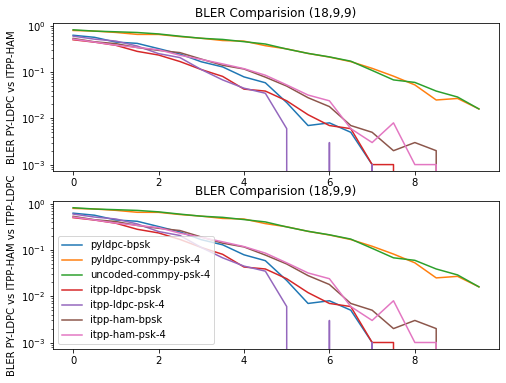

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_bpsk,'', label="itpp-ldpc-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax1.set_ylabel('BLER PY-LDPC vs ITPP-HAM')
ax1.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ldpc_itpp_bpsk,'', label="itpp-ldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax2.set_ylabel('BLER PY-LDPC vs ITPP-HAM vs ITPP-LDPC')
ax2.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [24]:
import numpy
def bit_error_ratio_uncoded_awgn_bpsk(snr_db):
  
    '''Generate random bits'''
    nrof_bits = 3 * 100000
    source_bits = itpp.base.randb(nrof_bits)
    
    '''Modulate the bits'''
    modulator = itpp.comm.BPSK()
    tx_signal = modulator.modulate_bits(source_bits)
    
    '''Add the effect of channel to the signal'''
    #noise_variance = itpp.math.inv_dB(-snr_db)
    noise_variance = 10 ** (-snr_db * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)

    rx_signal = channel(tx_signal)
    
    '''Demodulate the signal'''
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    
    '''Calculate the bit error ratio'''
    return itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0) / nrof_bits

def bit_error_ratio_uncoded_awgn_bpsk_c(snr_db):
    '''Generate random bits'''
    nrof_bits = 3 * 100000
    source_bits = itpp.base.randb(nrof_bits)
    
    '''Modulate the bits'''
    modulator = itpp.comm.BPSK_c()
    tx_signal = modulator.modulate_bits(source_bits)
    
    '''Add the effect of channel to the signal'''
    #noise_variance = itpp.math.inv_dB(-snr_db)
    noise_variance = 10 ** (-snr_db * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)

    rx_signal = channel(tx_signal)
    
    '''Demodulate the signal'''
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    
    '''Calculate the bit error ratio'''
    return itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0) / nrof_bits

def bit_error_ratio_uncoded_awgn_xxx(snr_db, n):
    '''Generate random bits'''
    nrof_bits = 3 * 100000
    source_bits = itpp.base.randb(nrof_bits)
    
    '''Modulate the bits'''
    modulator = itpp.comm.PSK(n)
    tx_signal = modulator.modulate_bits(source_bits)
    
    '''Add the effect of channel to the signal'''
    #noise_variance = itpp.math.inv_dB(-snr_db)
    noise_variance = 10 ** (-snr_db * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)

    rx_signal = channel(tx_signal)
    
    '''Demodulate the signal'''
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    
    '''Calculate the bit error ratio'''
    return itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0) / nrof_bits

'''SNR range'''
snrs_db = numpy.arange (SNR_BEGIN, SNR_END+20, SNR_STEP_SIZE)

print('BER Started')
ber_itpp_uncoded_bpsk = [bit_error_ratio_uncoded_awgn_bpsk(snr) for snr in snrs_db]
ber_itpp_uncoded_bpsk_c = [bit_error_ratio_uncoded_awgn_bpsk_c(snr) for snr in snrs_db]
ber_itpp_uncoded_psk_2 = [bit_error_ratio_uncoded_awgn_xxx(snr, 2) for snr in snrs_db]
ber_itpp_uncoded_psk_4 = [bit_error_ratio_uncoded_awgn_xxx(snr, 4) for snr in snrs_db]
ber_itpp_uncoded_psk_8 = [bit_error_ratio_uncoded_awgn_xxx(snr, 8) for snr in snrs_db]
ber_itpp_uncoded_psk_16 = [bit_error_ratio_uncoded_awgn_xxx(snr, 16) for snr in snrs_db]
print('BER Finished')

BER Started
BER Finished


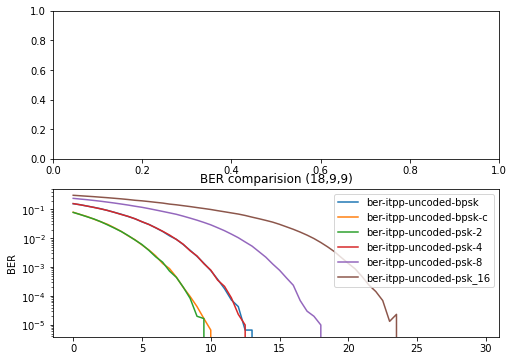

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END+20, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax2.semilogy(snrs_db,ber_itpp_uncoded_bpsk,'', label="ber-itpp-uncoded-bpsk") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_bpsk_c,'', label="ber-itpp-uncoded-bpsk-c") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_psk_2,'', label="ber-itpp-uncoded-psk-2") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_psk_4,'', label="ber-itpp-uncoded-psk-4") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_psk_8,'', label="ber-itpp-uncoded-psk-8") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_psk_16,'', label="ber-itpp-uncoded-psk_16") # plot BER vs SNR
ax2.set_ylabel('BER')
ax2.set_title('BER comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.annotate('',
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
#plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

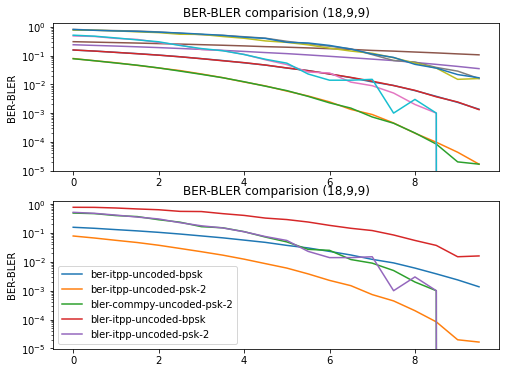

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_itpp_uncoded_bpsk[0:20],'', label="ber-itpp-uncoded-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,ber_itpp_uncoded_bpsk_c[0:20],'', label="ber-itpp-uncoded-bpsk-c") # plot BER vs SNR
ax1.semilogy(snrs,ber_itpp_uncoded_psk_2[0:20],'', label="ber-itpp-uncoded-psk_2") # plot BER vs SNR
ax1.semilogy(snrs,ber_itpp_uncoded_psk_4[0:20],'', label="ber-itpp-uncoded-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,ber_itpp_uncoded_psk_8[0:20],'', label="ber-itpp-uncoded-psk-8") # plot BER vs SNR
ax1.semilogy(snrs,ber_itpp_uncoded_psk_16[0:20],'', label="ber-itpp-uncoded-psk-16") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2 ,'', label="bler-commpy-uncoded-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="bler-commpy-uncoded-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_bpsk,'', label="bler-itpp-uncoded-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="bler-itpp-uncoded-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_4,'', label="bler-itpp-uncoded-psk-4") # plot BER vs SNR
ax1.set_ylabel('BER-BLER')
ax1.set_title('BER-BLER comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax1.annotate('',
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
ax2.semilogy(snrs,ber_itpp_uncoded_bpsk[0:20],'', label="ber-itpp-uncoded-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,ber_itpp_uncoded_psk_2[0:20],'', label="ber-itpp-uncoded-psk-2") # plot BER vs SNR
#ax2.semilogy(snrs,ber_unc_qpsk[0:20],'', label="ber_unc_qpsk") # plot BER vs SNR
#ax2.semilogy(snrs,ber_unc_8psk[0:20],'', label="ber_unc_8psk") # plot BER vs SNR
#ax2.semilogy(snrs,ber_unc_16psk[0:20],'', label="ber_unc_16psk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2 ,'', label="bler-commpy-uncoded-psk-2") # plot BER vs SNR
#ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="commpy-uncoded-qpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_bpsk,'', label="bler-itpp-uncoded-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="bler-itpp-uncoded-psk-2") # plot BER vs SNR
#ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_4,'', label="itpp-uncoded-psk-4") # plot BER vs SNR
ax2.set_ylabel('BER-BLER')
ax2.set_title('BER-BLER comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.annotate('',
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
#plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

No Bit Errors :)
No Bit Errors :)
No Bit Errors :)


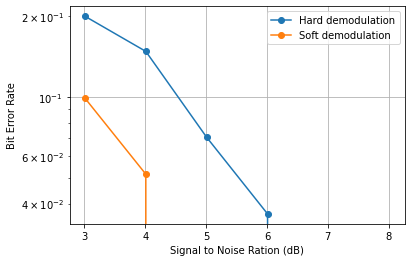

In [27]:
#https://github.com/veeresht/CommPy/blob/master/commpy/examples/conv_encode_decode.py
# Authors: CommPy contributors
# License: BSD 3-Clause

from __future__ import division, print_function  # Python 2 compatibility

import math

import matplotlib.pyplot as plt
import numpy as np

import commpy.channelcoding.convcode as cc
import commpy.channels as chan
import commpy.links as lk
import commpy.modulation as mod
import commpy.utilities as util

# =============================================================================
# Convolutional Code 1: G(D) = [1+D^2, 1+D+D^2]
# Standard code with rate 1/2
# =============================================================================

# Number of delay elements in the convolutional encoder
memory = np.array(2, ndmin=1)

# Generator matrix
g_matrix = np.array((0o5, 0o7), ndmin=2)

# Create trellis data structure
trellis1 = cc.Trellis(memory, g_matrix)

# =============================================================================
# Convolutional Code 1: G(D) = [1+D^2, 1+D^2+D^3]
# Standard code with rate 1/2
# =============================================================================

# Number of delay elements in the convolutional encoder
memory = np.array(3, ndmin=1)

# Generator matrix (1+D^2+D^3 <-> 13 or 0o15)
g_matrix = np.array((0o5, 0o15), ndmin=2)

# Create trellis data structure
trellis2 = cc.Trellis(memory, g_matrix)

# =============================================================================
# Convolutional Code 2: G(D) = [[1, 0, 0], [0, 1, 1+D]]; F(D) = [[D, D], [1+D, 1]]
# RSC with rate 2/3
# =============================================================================

# Number of delay elements in the convolutional encoder
memory = np.array((1, 1))

# Generator matrix & feedback matrix
g_matrix = np.array(((1, 0, 0), (0, 1, 3)))
feedback = np.array(((2, 2), (3, 1)))

# Create trellis data structure
trellis3 = cc.Trellis(memory, g_matrix, feedback, 'rsc')

# =============================================================================
# Basic example using homemade counting and hard decoding
# =============================================================================

# Traceback depth of the decoder
tb_depth = None  # Default value is 5 times the number or memories

for trellis in (trellis1, trellis2, trellis3):
    for i in range(10):
        # Generate random message bits to be encoded
        message_bits = np.random.randint(0, 2, 1000)

        # Encode message bits
        coded_bits = cc.conv_encode(message_bits, trellis)

        # Introduce bit errors (channel)
        coded_bits[np.random.randint(0, 1000)] = 0
        coded_bits[np.random.randint(0, 1000)] = 0
        coded_bits[np.random.randint(0, 1000)] = 1
        coded_bits[np.random.randint(0, 1000)] = 1

        # Decode the received bits
        decoded_bits = cc.viterbi_decode(coded_bits.astype(float), trellis, tb_depth)

        num_bit_errors = util.hamming_dist(message_bits, decoded_bits[:len(message_bits)])

        if num_bit_errors != 0:
            print(num_bit_errors, "Bit Errors found!")
        elif i == 9:
            print("No Bit Errors :)")

# ==================================================================================================
# Complete example using Commpy features and compare hard and soft demodulation. Example with code 1
# ==================================================================================================

# Modem : QPSK
modem = mod.QAMModem(4)

# AWGN channel
channels = chan.SISOFlatChannel(None, (1 + 0j, 0j))

# SNR range to test
SNRs = np.arange(0, 6) + 10 * math.log10(modem.num_bits_symbol)


# Modulation function
def modulate(bits):
    return modem.modulate(cc.conv_encode(bits, trellis1, 'cont'))


# Receiver function (no process required as there are no fading)
def receiver_hard(y, h, constellation, noise_var):
    return modem.demodulate(y, 'hard')


# Receiver function (no process required as there are no fading)
def receiver_soft(y, h, constellation, noise_var):
    return modem.demodulate(y, 'soft', noise_var)


# Decoder function
def decoder_hard(msg):
    return cc.viterbi_decode(msg, trellis1)


# Decoder function
def decoder_soft(msg):
    return cc.viterbi_decode(msg, trellis1, decoding_type='soft')


# Build model from parameters
code_rate = trellis1.k / trellis1.n
model_hard = lk.LinkModel(modulate, channels, receiver_hard,
                          modem.num_bits_symbol, modem.constellation, modem.Es,
                          decoder_hard, code_rate)
model_soft = lk.LinkModel(modulate, channels, receiver_soft,
                          modem.num_bits_symbol, modem.constellation, modem.Es,
                          decoder_soft, code_rate)

# Test
BERs_hard = model_hard.link_performance(SNRs, 10000, 600, 5000, code_rate)
BERs_soft = model_soft.link_performance(SNRs, 10000, 600, 5000, code_rate)
plt.semilogy(SNRs, BERs_hard, 'o-', SNRs, BERs_soft, 'o-')
plt.grid()
plt.xlabel('Signal to Noise Ration (dB)')
plt.ylabel('Bit Error Rate')
plt.legend(('Hard demodulation', 'Soft demodulation'))
plt.show()